# Notebook 1: Rolling Mean vs Rolling Median

## Introduction

This notebook demonstrates the difference between **rolling mean** and **rolling median** for smoothing time-series data.

**Key question**: When sensor data contains occasional **outliers** or **spikes** (sensor errors, transmission glitches, etc.), which smoothing method is more robust?

We'll use daily temperature data from a weather station that occasionally reports erroneous readings.

---

## Setup

Import HPCSeries and load the climate data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hpcs

# Display library info
print(f"HPCSeries version: {hpcs.__version__}")
print(f"SIMD ISA: {hpcs.simd_info()['isa']}")
print()

HPCSeries version: 0.7.0
SIMD ISA: AVX2

=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T


[SIMD] Registered OpenMP SIMD reduction kernels
[SIMD] Registered OpenMP SIMD rolling operations
[SIMD] Z-score kernels initialized
[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


## Load Data

Load one year of daily temperature readings. This dataset contains:
- 365 days of temperature data (°F)
- Realistic seasonal variation (cold in winter, hot in summer)
- **Several sensor error spikes** (erroneous high/low readings)

In [2]:
# Load climate data
df = pd.read_csv('data/climate_daily_temp.csv')
df['date'] = pd.to_datetime(df['date'])

# Extract temperature as NumPy array
temp = df['temperature_celsius'].values

print(f"Dataset: {len(temp)} days of temperature data")
print(f"Temperature range: {temp.min():.1f}°F - {temp.max():.1f}°F")
print(f"Mean temperature: {temp.mean():.1f}°F")
print()

# Show first few rows
df.head(10)

Dataset: 365 days of temperature data
Temperature range: 3.7°F - 111.2°F
Mean temperature: 55.1°F



,date,temperature_celsius,location
0,2023-01-01,5.2,Weather_Station_01
1,2023-01-02,4.8,Weather_Station_01
2,2023-01-03,6.1,Weather_Station_01
3,2023-01-04,5.9,Weather_Station_01
4,2023-01-05,4.3,Weather_Station_01
5,2023-01-06,3.7,Weather_Station_01
6,2023-01-07,28.5,Weather_Station_01
7,2023-01-08,4.1,Weather_Station_01
8,2023-01-09,5.3,Weather_Station_01
9,2023-01-10,6.2,Weather_Station_01


## Visualize Raw Data

Plot the raw temperature time-series. Notice the **sensor spikes** scattered throughout the year.

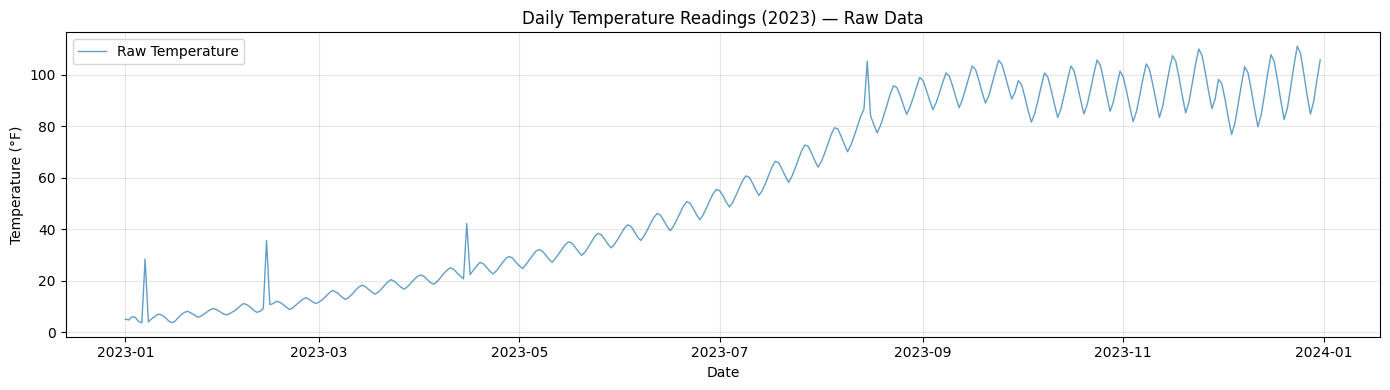

In [3]:
plt.figure(figsize=(14, 4))
plt.plot(df['date'], temp, alpha=0.7, linewidth=1, label='Raw Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.title('Daily Temperature Readings (2023) — Raw Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Apply Rolling Mean (7-day window)

Compute a **7-day rolling mean** using HPCSeries. This is the standard approach for smoothing time-series data.

In [4]:
window = 7

# HPCSeries rolling mean (SIMD-accelerated)
rolling_mean_hpcs = hpcs.rolling_mean(temp, window)

print(f"Rolling mean computed: {len(rolling_mean_hpcs)} values")
print(f"Rolling mean range: {np.nanmin(rolling_mean_hpcs):.1f}°F - {np.nanmax(rolling_mean_hpcs):.1f}°F")
print()

Rolling mean computed: 365 values
Rolling mean range: 5.0°F - 100.3°F



## Apply Rolling Median (7-day window)

Compute a **7-day rolling median** using HPCSeries. This is a **robust** alternative that is less sensitive to outliers.

In [5]:
# HPCSeries rolling median (fast C++ implementation)
rolling_median_hpcs = hpcs.rolling_median(temp, window)

print(f"Rolling median computed: {len(rolling_median_hpcs)} values")
print(f"Rolling median range: {np.nanmin(rolling_median_hpcs):.1f}°F - {np.nanmax(rolling_median_hpcs):.1f}°F")
print()

Rolling median computed: 365 values
Rolling median range: 4.8°F - 100.8°F



## Comparison Plot: Mean vs Median

Plot all three:
1. **Raw data** (with sensor spikes)
2. **Rolling mean** (sensitive to spikes)
3. **Rolling median** (robust to spikes)

**Observation**: The rolling median produces a **smoother, more stable trend** because it ignores outliers.

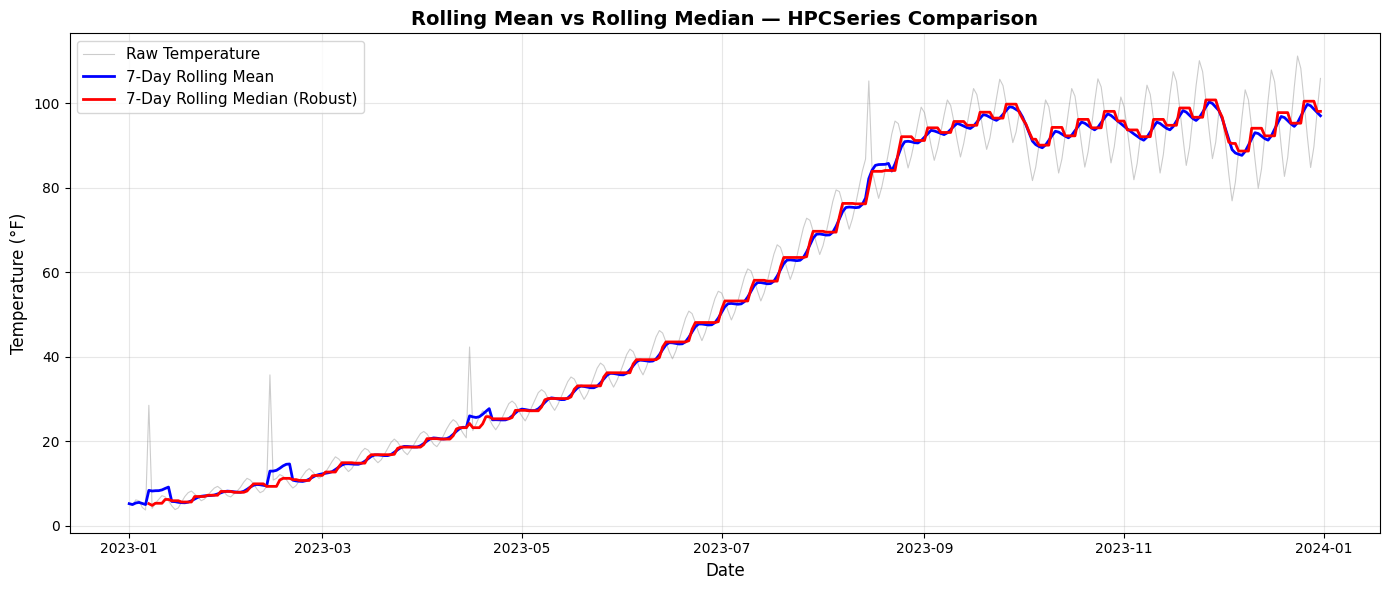

In [6]:
plt.figure(figsize=(14, 6))

# Raw data
plt.plot(df['date'], temp, alpha=0.4, linewidth=0.8, color='gray', label='Raw Temperature')

# Rolling mean
plt.plot(df['date'], rolling_mean_hpcs, linewidth=2, color='blue', label=f'{window}-Day Rolling Mean')

# Rolling median
plt.plot(df['date'], rolling_median_hpcs, linewidth=2, color='red', label=f'{window}-Day Rolling Median (Robust)')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.title('Rolling Mean vs Rolling Median — HPCSeries Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Zoom In: January — February

Let's zoom in on **January-February** where we know there are sensor spikes.

**Notice**:
- The **rolling mean** (blue) gets **pulled upward** by the spike.
- The **rolling median** (red) **ignores the spike** and maintains the true trend.

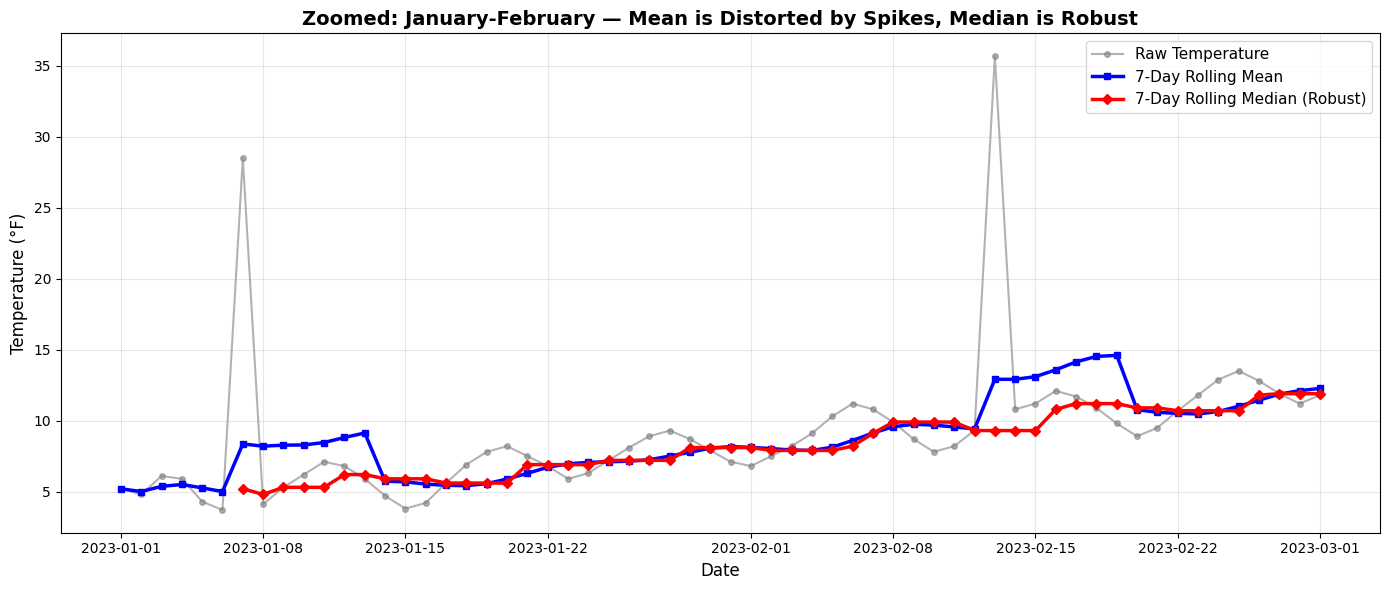

In [7]:
# Select January-February (first 60 days)
zoom_range = slice(0, 60)

plt.figure(figsize=(14, 6))

plt.plot(df['date'][zoom_range], temp[zoom_range], alpha=0.6, linewidth=1.5, color='gray', 
         marker='o', markersize=4, label='Raw Temperature')

plt.plot(df['date'][zoom_range], rolling_mean_hpcs[zoom_range], linewidth=2.5, color='blue', 
         marker='s', markersize=5, label=f'{window}-Day Rolling Mean')

plt.plot(df['date'][zoom_range], rolling_median_hpcs[zoom_range], linewidth=2.5, color='red', 
         marker='D', markersize=5, label=f'{window}-Day Rolling Median (Robust)')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Temperature (°F)', fontsize=12)
plt.title('Zoomed: January-February — Mean is Distorted by Spikes, Median is Robust', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Performance Benchmark

HPCSeries uses **SIMD-accelerated** rolling mean and **fast C++ sorting** for rolling median.

Let's measure the performance on a larger dataset.

In [8]:
import time

# Create large test array
n = 1_000_000
large_data = np.random.randn(n) * 15 + 60  # Simulated temperature data

print(f"Benchmark: {n:,} element array, window={window}\n")

# Benchmark rolling mean
start = time.perf_counter()
_ = hpcs.rolling_mean(large_data, window)
elapsed_mean = time.perf_counter() - start
print(f"Rolling Mean:   {elapsed_mean*1000:.2f} ms  ({n/elapsed_mean/1e6:.1f} M elements/sec)")

# Benchmark rolling median
start = time.perf_counter()
_ = hpcs.rolling_median(large_data, window)
elapsed_median = time.perf_counter() - start
print(f"Rolling Median: {elapsed_median*1000:.2f} ms  ({n/elapsed_median/1e6:.1f} M elements/sec)")

print(f"\nMedian is {elapsed_median/elapsed_mean:.1f}x slower than mean (expected, due to sorting)")

Benchmark: 1,000,000 element array, window=7

Rolling Mean:   10.57 ms  (94.6 M elements/sec)
Rolling Median: 160.21 ms  (6.2 M elements/sec)

Median is 15.2x slower than mean (expected, due to sorting)


## What We Learned

### Key Takeaways:

1. **Rolling mean** is fast and smooth, but **sensitive to outliers**.
   - Sensor spikes cause the rolling mean to deviate from the true trend.

2. **Rolling median** is **robust to outliers** and produces a cleaner trend.
   - It ignores sensor errors and tracks the underlying seasonal pattern.

3. **HPCSeries provides both**:
   - `hpcs.rolling_mean()` — SIMD-accelerated, extremely fast
   - `hpcs.rolling_median()` — Fast C++ implementation, robust statistics

### When to Use Each:

| Use Case | Recommended Method |
|----------|-------------------|
| Clean data with no outliers | `rolling_mean` (faster) |
| Noisy sensors with occasional spikes | `rolling_median` (robust) |
| Financial data with extreme events | `rolling_median` |
| IoT/environmental sensors | `rolling_median` |
| High-frequency trading signals | `rolling_mean` (speed critical) |

---

## Next Steps

See the next notebook:
- **Notebook 2**: Robust anomaly detection on climate data using `hpcs.detect_anomalies_robust()`
